# "Involvement" Factor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re

In [2]:
house = pd.read_csv("../data/sw_crsp_house.zip")
house[:5]

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,...,disdeclaredt,disrecorddt,dispaydt,dispermno,dispermco,vwretd,vwretx,ewretd,ewretx,sprtrn
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,...,NaN,NaN,NaN,NaN,NaN,-0.000980,-0.001009,0.008200,0.008166,-0.002776
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,...,NaN,NaN,NaN,NaN,NaN,0.001957,0.001948,0.001363,0.001328,0.002277
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,...,NaN,NaN,NaN,NaN,NaN,-0.007309,-0.007346,-0.005727,-0.005794,-0.007723
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,...,2021-09-15,2021-09-29,2021-10-14,0.0,0.0,-0.020769,-0.020804,-0.016825,-0.016841,-0.020364
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,...,NaN,NaN,NaN,NaN,NaN,-0.007397,-0.007438,-0.000968,-0.001051,-0.009111


## Data Cleanup and Group

In [3]:
UPPER_BOUND = 100000000 # assumed upper bound for category "$50,000,000+"

In [4]:
# parse transaction amount
def parse_amount(string):
    split = re.split(r'\s+|\s-', re.sub("\$", "", re.sub(",", "", string)))
    if len(split) == 2:
        if int(split[0]) % 10 != 1:
            split[0] = int(split[0]) + 1
        res = (int(split[0]), UPPER_BOUND) if split[1] == "+" else (1, int(split[0]))
    elif len(split) == 3:
        if int(split[0]) % 10 != 1:
            split[0] = int(split[0]) + 1
        if int(split[2]) % 10 != 1:
            split[2] = int(split[2]) + 1
        res = (int(split[0]), int(split[2]))
    
    return res

v_parse_amount = np.vectorize(parse_amount)

In [5]:
house_valid = house.dropna(subset=["amount", "transaction_date"])
house_valid["ticker"] = house_valid["ticker"].replace("--", np.nan)
house_valid = house_valid.dropna(subset=["ticker"])
house_valid["amount_lower"], house_valid["amount_upper"] = v_parse_amount(house_valid["amount"])
house_valid["transaction_date"] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), house_valid["transaction_date"]))

In [6]:
house_valid[["transaction_date", "ticker", "amount_lower", "amount_upper"]].dtypes

transaction_date    object
ticker              object
amount_lower         int32
amount_upper         int32
dtype: object

In [7]:
transaction_dates = house_valid.groupby(["ticker", "district", "representative"])["transaction_date"].apply(list).reset_index()
amount_lowers = house_valid.groupby(["ticker", "district", "representative"])["amount_lower"].apply(list).reset_index()
amount_uppers = house_valid.groupby(["ticker", "district", "representative"])["amount_upper"].apply(list).reset_index()

In [8]:
house_grouped = transaction_dates.merge(amount_lowers).merge(amount_uppers)
house_grouped["count"] = list(map(len, house_grouped["transaction_date"]))
house_grouped

,ticker,district,representative,transaction_date,amount_lower,amount_upper,count
0,35G.SG,TX10,Hon. Michael T. McCaul,"[2021-02-26 00:00:00, 2021-02-26 00:00:00]","[1001, 1001]","[15001, 15001]",2
1,7XY,VT00,Hon. Peter Welch,[2021-11-19 00:00:00],[15001],[50001],1
2,A,MI03,Mr. Peter Meijer,[2021-02-16 00:00:00],[1001],[15001],1
3,A,VT00,Hon. Peter Welch,"[2020-04-09 00:00:00, 2021-11-18 00:00:00]","[1001, 1001]","[15001, 15001]",2
4,AA,CT01,Hon. John B. Larson,[2019-12-18 00:00:00],[15001],[50001],1
...,...,...,...,...,...,...,...
5740,ZTS,OR05,Hon. Kurt Schrader,[2022-01-06 00:00:00],[1001],[15001],1
5741,ZTS,TX10,Hon. Michael T. McCaul,"[2020-11-25 00:00:00, 2020-11-25 00:00:00]","[15001, 15001]","[50001, 50001]",2
5742,ZTS,UT03,Hon. John Curtis,"[2020-03-27 00:00:00, 2022-06-28 00:00:00]","[1001, 1001]","[15001, 15001]",2
5743,ZUO,FL18,Hon. Brian Mast,"[2020-09-03 00:00:00, 2020-12-11 00:00:00]","[15001, 15001]","[50001, 50001]",2


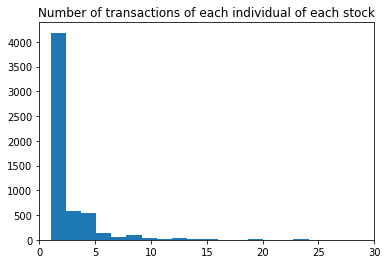

In [9]:
plt.hist(house_grouped["count"], bins=100)
plt.xlim(0, 30)
plt.title("Number of transactions of each individual of each stock");

## Hypothetical ESG stock Category

Before we get the dataset categorizing ESG stocks from others, we will do the following exercise using randomly generated labels.   
_TODO: replace with actual ESG catgorizations._ 

In [10]:
# hypothetical labels (waiting for ESG classification)
np.random.seed(42)
esg = pd.DataFrame({"ticker": house_grouped["ticker"].unique(), 
                    "esg": np.random.choice(2, len(house_grouped["ticker"].unique()), p=[0.9, 0.1])})
esg

,ticker,esg
0,35G.SG,0
1,7XY,1
2,A,0
3,AA,0
4,AAGIY,0
...,...,...
2196,ZM,0
2197,ZNGA,0
2198,ZOOM,0
2199,ZTS,0


In [11]:
house_esg = house_grouped.merge(esg)
house_esg_grouped = house_esg.groupby(["district", "representative", "esg"])\
                                      [["transaction_date", "amount_lower", "amount_upper"]].sum()
house_esg_grouped["count"] = list(map(len, house_esg_grouped["transaction_date"]))
house_esg_grouped

transaction_date  \
district representative              esg                                                      
AL02     Hon. Felix Barry Moore      0    [2021-10-23 00:00:00, 2021-05-11 00:00:00, 202...   
AL05     Hon. Mo Brooks              0    [2020-04-13 00:00:00, 2022-07-22 00:00:00, 202...   
                                     1    [2020-01-15 00:00:00, 2020-01-02 00:00:00, 202...   
AR02     Hon. James French Hill      0    [2019-12-19 00:00:00, 2020-11-30 00:00:00, 202...   
                                     1                                [2020-11-30 00:00:00]   
...                                                                                     ...   
WI08     Hon. Michael John Gallagher 1    [2020-01-13 00:00:00, 2019-12-16 00:00:00, 202...   
WV01     Hon. David B. McKinley      0    [2020-03-09 00:00:00, 2020-03-23 00:00:00, 202...   
                                     1    [2020-08-28 00:00:00, 2020-04-30 00:00:00, 202...   
WV03     Hon. Carol Devine Miller    0    [2019-07-02 00:00:00, 2021-03-04 00:00:00, 202...   
                                     1    [2021-12-14 00:00:00, 2020-07-28 00:00:00, 202...   

                                                                               amount_lower  \
district representative              esg                                                      
AL02     Hon. Felix Barry Moore      0                 [1001, 1001, 1001, 1001, 1001, 1001]   
AL05     Hon. Mo Brooks              0    [1001, 1001, 1001, 15001, 1001, 15001, 1001, 1...   
                                     1                       [1001, 1001, 1001, 1001, 1001]   
AR02     Hon. James French Hill      0    [15001, 1001, 1001, 15001, 15001, 1001, 1001, ...   
                                     1                                               [1001]   
...                                                                                     ...   
WI08     Hon. Michael John Gallagher 1                             [1001, 1001, 1001, 1001]   
WV01     Hon. David B. McKinley      0    [1001, 1001, 15001, 1001, 1001, 1001, 50001, 1...   
                                     1    [1001, 1, 1001, 1001, 15001, 1001, 1001, 1001,...   
WV03     Hon. Carol Devine Miller    0    [15001, 1001, 15001, 1001, 15001, 15001, 15001...   
                                     1                   [15001, 1001, 15001, 15001, 15001]   

                                                                               amount_upper  \
district representative              esg                                                      
AL02     Hon. Felix Barry Moore      0           [15001, 15001, 15001, 15001, 15001, 15001]   
AL05     Hon. Mo Brooks              0    [15001, 15001, 15001, 50001, 15001, 50001, 150...   
                                     1                  [15001, 15001, 15001, 15001, 15001]   
AR02     Hon. James French Hill      0    [50001, 15001, 15001, 50001, 50001, 15001, 150...   
                                     1                                              [15001]   
...                                                                                     ...   
WI08     Hon. Michael John Gallagher 1                         [15001, 15001, 15001, 15001]   
WV01     Hon. David B. McKinley      0    [15001, 15001, 50001, 15001, 15001, 15001, 100...   
                                     1    [15001, 1001, 15001, 15001, 50001, 15001, 1500...   
WV03     Hon. Carol Devine Miller    0    [50001, 15001, 50001, 15001, 50001, 50001, 500...   
                                     1                  [50001, 15001, 50001, 50001, 50001]   

                                          count  
district representative              esg         
AL02     Hon. Felix Barry Moore      0        6  
AL05     Hon. Mo Brooks              0       38  
                                     1        5  
AR02     Hon. James French Hill      0        9  
                                     1        1  
...              

## Baseline Involvement Factor
Here I define ESG "involvement" factor $I_i$: 

$$ I_i = \frac{T^e_i}{T^e_i + T^n_i}$$

where
- $T^e_i$: number of ESG stocks transactions (`esg` = 1)
- $T^n_i$: number of non-ESG stocks transactions (`esg` = 0)

_Note:_ There are a lot of caveats with this baseline approach. For example, the volumn for each transaction should play a role; stock long/short holding position should also matter (an individual holding a stock definitely implies as much involvement as buy/sell a stock); factor should also be time-dependent (closer to the time of transaction, higher the involvement), etc. These will be the things that can be examined and introduced into the model at a later time. 

In [12]:
# baseline "involvement" factor
house_esg_grouped_b = house_esg_grouped.reset_index()
house_esg_grouped_b

,district,representative,esg,transaction_date,amount_lower,amount_upper,count
0,AL02,Hon. Felix Barry Moore,0,"[2021-10-23 00:00:00, 2021-05-11 00:00:00, 202...","[1001, 1001, 1001, 1001, 1001, 1001]","[15001, 15001, 15001, 15001, 15001, 15001]",6
1,AL05,Hon. Mo Brooks,0,"[2020-04-13 00:00:00, 2022-07-22 00:00:00, 202...","[1001, 1001, 1001, 15001, 1001, 15001, 1001, 1...","[15001, 15001, 15001, 50001, 15001, 50001, 150...",38
2,AL05,Hon. Mo Brooks,1,"[2020-01-15 00:00:00, 2020-01-02 00:00:00, 202...","[1001, 1001, 1001, 1001, 1001]","[15001, 15001, 15001, 15001, 15001]",5
3,AR02,Hon. James French Hill,0,"[2019-12-19 00:00:00, 2020-11-30 00:00:00, 202...","[15001, 1001, 1001, 15001, 15001, 1001, 1001, ...","[50001, 15001, 15001, 50001, 50001, 15001, 150...",9
4,AR02,Hon. James French Hill,1,[2020-11-30 00:00:00],[1001],[15001],1
...,...,...,...,...,...,...,...
272,WI08,Hon. Michael John Gallagher,1,"[2020-01-13 00:00:00, 2019-12-16 00:00:00, 202...","[1001, 1001, 1001, 1001]","[15001, 15001, 15001, 15001]",4
273,WV01,Hon. David B. McKinley,0,"[2020-03-09 00:00:00, 2020-03-23 00:00:00, 202...","[1001, 1001, 15001, 1001, 1001, 1001, 50001, 1...","[15001, 15001, 50001, 15001, 15001, 15001, 100...",138
274,WV01,Hon. David B. McKinley,1,"[2020-08-28 00:00:00, 2020-04-30 00:00:00, 202...","[1001, 1, 1001, 1001, 15001, 1001, 1001, 1001,...","[15001, 1001, 15001, 15001, 50001, 15001, 1500...",14
275,WV03,Hon. Carol Devine Miller,0,"[2019-07-02 00:00:00, 2021-03-04 00:00:00, 202...","[15001, 1001, 15001, 1001, 15001, 15001, 15001...","[50001, 15001, 50001, 15001, 50001, 50001, 500...",61


In [13]:
def involvement_factor(data, d, r):
    subset = data[(data["district"] == d) & (data["representative"] == r)]
    esg = subset[subset["esg"] == 1]
    non_esg = subset[subset["esg"] == 0]
    if len(esg) > 0:
        esg_count = esg["count"].iloc[0]
    else:
        esg_count = 0
        
    if len(non_esg) > 0:
        non_esg_count = non_esg["count"].iloc[0]
    else:
        non_esg_count = 0
    
    return esg_count / (esg_count + non_esg_count)

In [14]:
# example
involvement_factor(house_esg_grouped_b, "AL02", "Hon. Felix Barry Moore")

0.0

In [15]:
# example
involvement_factor(house_esg_grouped_b, "AL05", "Hon. Mo Brooks")

0.11627906976744186

In [16]:
# generate involvement factor for all data entries
involvement_factor_table_helper = lambda d, r: involvement_factor(house_esg_grouped_b, d, r)
house_esg_grouped_b["inv_factor"] = list(map(involvement_factor_table_helper, house_esg_grouped_b["district"], house_esg_grouped_b["representative"]))
house_inv_factors = house_esg_grouped_b.groupby(["district", "representative"])[["inv_factor"]].first()
house_inv_factors

inv_factor
district representative                         
AL02     Hon. Felix Barry Moore         0.000000
AL05     Hon. Mo Brooks                 0.116279
AR02     Hon. James French Hill         0.100000
AZ01     Hon. Tom O'Halleran            0.000000
AZ03     Hon. Raúl M. Grijalva          0.000000
...                                          ...
WA08     Hon. Kim Dr Schrier            0.142857
         Hon. Kim Schrier               0.000000
WI08     Hon. Michael John Gallagher    0.105263
WV01     Hon. David B. McKinley         0.092105
WV03     Hon. Carol Devine Miller       0.075758

[175 rows x 1 columns]

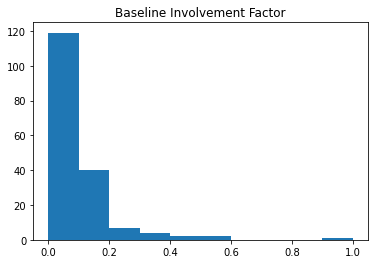

In [17]:
plt.hist(house_inv_factors)
plt.title("Baseline Involvement Factor");